<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/7_generative_variational_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Variational Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com/, a website that shows faces generated by a recent GAN architecture called StyleGAN (you can also check out https://thisrentaldoesnotexist.com/ to see some generated Airbnb bedrooms).

GANs are now widely used for super resolution (increasing the resolution of
an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models and strengthening them, and more.

Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications.

However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

* GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake.

We will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will start by building a simple GAN to generate fake images, but we will see that training is often quite difficult.



## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


A couple utility functions to plot grayscale 28x28 image:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Variational Autoencoders

Another important category of autoencoders was introduced in [2013 by Diederik Kingma and Max Welling](https://arxiv.org/abs/1312.6114) and quickly became one of the most popular types of autoencoders: **variational autoencoders**.

They are quite different from all the autoencoders we have discussed so far, in these particular ways:

* They are probabilistic autoencoders, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).
* Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.

Both these properties make them rather similar to RBMs, but they are easier to train, and the sampling process is much faster (with RBMs you need to wait for the network to stabilize into a “thermal equilibrium” before you can sample a new instance).

Indeed, as their name suggests, variational autoencoders perform variational Bayesian inference which is an efficient way to perform
approximate Bayesian inference.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/variational-autoencoder.png?raw=1' width='800'/>

As you can see in the diagram, although the inputs may have a very convoluted distribution, a variational autoencoder tends to produce codings that look as though they were sampled from a simple Gaussian distribution: during training, the cost function pushes the codings to gradually migrate within the coding space (also called the latent space) to end up looking like a cloud of Gaussian points. One great consequence is that after training a variational autoencoder, you can very easily generate a new instance: just sample a random coding from the Gaussian distribution,
decode it, and voilà!


Let's load MNIST dataset.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


Let’s start building a variational autoencoder for Fashion MNIST.First, we will need a custom layer to sample the codings, given μ and γ:


In [0]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

Next, we can create the encoder, using the Functional API because the model is not entirely sequential:

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)      
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs  = keras.layers.Input(shape=[codings_size])     
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28 * 28, activation='sigmoid')(x)

outputs = keras.layers.Reshape([28, 28])(x)

variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

variational_autoencoder = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# we must add the latent loss and the reconstruction loss
latent_loss = -0.5 * keras.backend.sum(1 + codings_log_var - keras.backend.exp(codings_log_var) - keras.backend.square(codings_mean), axis=1)
'''
Then we compute the mean loss over all the instances in the batch, and we divide the result by 784 
to ensure it has the appropriate scale compared to the reconstruction loss.
'''
variational_autoencoder.add_loss(keras.backend.mean(latent_loss / 784.))

variational_autoencoder.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[rounded_accuracy])

history = variational_autoencoder.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 121us/sample - loss: 0.3895 - rounded_accuracy: 0.8599 - val_loss: 0.3465 - val_rounded_accuracy: 0.8994
Epoch 2/25
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3428 - rounded_accuracy: 0.8972 - val_loss: 0.3375 - val_rounded_accuracy: 0.9037
Epoch 3/25
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3327 - rounded_accuracy: 0.9050 - val_loss: 0.3314 - val_rounded_accuracy: 0.9100
Epoch 4/25
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3276 - rounded_accuracy: 0.9091 - val_loss: 0.3282 - val_rounded_accuracy: 0.9083
Epoch 5/25
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3246 - rounded_accuracy: 0.9115 - val_loss: 0.3237 - val_rounded_accuracy: 0.9132
Epoch 6/25
55000/55000 [==============================] - 4s 70us/sample - loss: 0.3224 - rounded_accuracy: 0.9135 - val_loss

In [7]:
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 150)          117750      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          15100       dense[0][0]                      
______________________________________________________________________________________________

In [8]:
variational_decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_5 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 134,634
Trainable params: 134,634
Non-trainable params: 0
_________________________________________________________________


### Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. 

Let’s plot a few images from the validation set, as well as their reconstructions:

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

Let's see a few noisy images (with half the pixels turned off), and the
images reconstructed by the GaussianNoise based denoising autoencoder.

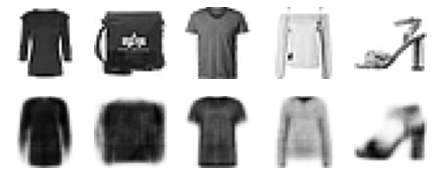

In [10]:
show_reconstructions(variational_autoencoder)
plt.show()

## Generate Fashion Images

Now let’s use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution and decode them:

In [0]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))

  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

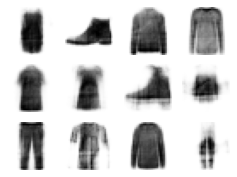

In [13]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

The majority of these images look fairly convincing, if a bit too fuzzy. The rest are not great, but don’t be too harsh on the autoencoder—it only had a few minutes to learn! Give it a bit more fine-tuning and training time, and those images should look better.

Variational autoencoders make it possible to perform semantic interpolation: instead of interpolating two images at the pixel level (which would look as if the two images were overlaid), we can interpolate at the codings level. We first run both images through the encoder, then we interpolate the two codings we get, and finally we decode the interpolated codings to get the final image. It will look like a regular Fashion
MNIST image, but it will be an intermediate between the original images.

Now let's perform semantic interpolation between these images:

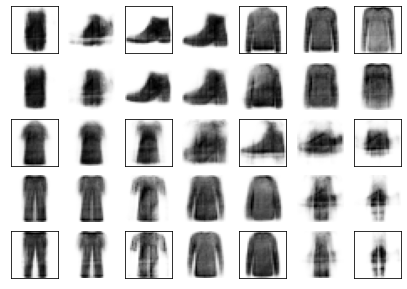

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

The original images are framed, and the rest are the result of semantic interpolation between the nearby images. Notice, for example, how the shoe in the fourth row and fifth column is a nice interpolation between the two shoes located above and below it.

For several years, variational autoencoders were quite popular, but GANs eventually took the lead, in particular because they are capable of generating much more realistic and crisp images. So let’s turn our attention to GANs.